# Filter Training Data


## Background

It is not uncommon for existing training data to be collected over a different time period than that of the study period. Meaning that a dataset may not reflect the real ground cover due to temporal changes. 

The Food and Agriculture Organization (FAO) adopted a training data filtering method for any given reference year that is within a time span (e.g. 5 years) from an existing baseline, and tested the method in the production of land cover mapping for Lesotho. It is assumed that the majority of reference labels will remain valid from one year to the previous/next. Based on this assumption, the reference labels which have changed are the minority, and should be detectable through the use of outlier detection methods like K-Means clustering. More details on the method and how it works for Lesotho can be found in the published paper ([De Simone et al 2022](https://www.mdpi.com/2072-4292/14/14/3294)).

## Description

This notebook will implement FAO's automatic filtering of a training dataset for a target year using points from a geojson or shapefile and a reference classification map of a previous year. The steps include:
1. Load extracted training features
2. Generate stratified random samples for each class on the reference land cover map using `random_sampling` and extract their features using `collect_training_data`
3. Train K-Means models using the extracted features of the random samples
4. Apply clustering on training features and remove minor clusters
5. Export the filtered training features to disk for use in subsequent scripts

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.  

Note: The approximate running time for the default setting is about an hour.

### Load packages


In [1]:
%matplotlib inline
import warnings
import datacube
import numpy as np
import geopandas as gpd
import pandas as pd
import xarray as xr
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from random_sampling import random_sampling # adapted from function by Chad Burton: https://gist.github.com/cbur24/04760d645aa123a3b1817b07786e7d9f
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.classification import collect_training_data
from deafrica_tools.datahandling import load_ard
from odc.io.cgroups import get_cpu_quota
from odc.algo import xr_geomedian
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pa

## Analysis parameters
* `training_features_path`: The path to the file containing training features we extracted through the previous module `1_Extract_Training_Features.ipynb`.
* `reference_map_path`: The path to the reference classification map, which will be used as a stratification layer to extract random samples for each class. In this example, we use the clipped and class-merged classification map produced from the notebook `0_Generate_Training_Points.ipynb`.**Note that the reference map pixel values should contain the class values existing in the training data.**
* `class_attr`: This is the name of column in your shapefile/geojson file attribute table that contains the class labels. **The class labels must be integers**
* `output_crs`: Output spatial reference system.

In [2]:
training_features_path = 'Results/Training_features.geojson'
reference_map_path='Results/rwanda_landcover_2015_scheme_ii_clipped.tif'
class_attr = 'LC_Class_I' # class label in integer format
output_crs='epsg:32735' # WGS84/UTM Zone 35S

## Load input data

We now load the training features .txt file using `geopandas`. The pandas dataframe should contain columns `class_attr` identifying class labels and the bi-monthly geomedians of the nine spectral bands and NDVI that we extracted through previous module. It also contains the coordinates and geometry columns.

In [3]:
training_features= gpd.read_file(training_features_path)
training_features.head() # Plot first five rows

,LC_Class_I,blue_0,blue_1,blue_2,blue_3,blue_4,blue_5,green_0,green_1,green_2,...,swir_2_5,NDVI_0,NDVI_1,NDVI_2,NDVI_3,NDVI_4,NDVI_5,x_coord,y_coord,geometry
0,10.0,552.311523,636.482727,434.500000,517.705444,793.366882,740.098511,773.294678,1023.597839,786.000000,...,2318.896973,0.406971,0.586414,0.573067,0.423769,0.351241,0.367363,847005.0,9769825.0,POINT (847005.000 9769825.000)
1,10.0,559.533569,1288.758179,430.151794,521.289246,721.967896,307.000000,790.738037,1673.564209,644.816040,...,1398.500000,0.697875,0.452891,0.755627,0.620328,0.569913,0.799792,851715.0,9774285.0,POINT (851715.000 9774285.000)
2,10.0,605.999939,680.500000,413.134064,514.050171,691.459351,687.000000,1013.999817,948.500000,702.840820,...,1560.500000,0.612483,0.616036,0.693201,0.587589,0.419678,0.530195,851475.0,9771945.0,POINT (851475.000 9771945.000)
3,10.0,946.741211,2437.500000,464.546265,610.075562,988.042358,522.236145,1151.546631,2717.500000,703.996582,...,637.218872,0.264174,0.188451,0.696107,0.482598,0.248337,0.581490,854545.0,9772785.0,POINT (854545.000 9772785.000)
4,10.0,1064.862305,506.292664,285.434601,522.204895,717.104858,666.887268,1185.977661,681.131775,490.491119,...,850.445007,0.487073,0.752476,0.845713,0.520688,0.447816,0.558978,850955.0,9769945.0,POINT (850955.000 9769945.000)


Using the `class_attr` column we can get the class values, which we will use later to process by class. For this extracted training points, the class names corresponding to the class values are: `1: Forest, 5: Grassland, 7: Shrubland, 9: Perennial Cropland, 10: Annual Cropland, 11: Wetland, 12: Water Body, 13: Urban Settlement, 14: Bare Land`.

In [4]:
lc_classes=training_features[class_attr].unique()
print('land cover classes:\n',lc_classes)

land cover classes:
 [10. 11. 12. 13.  7. 14.  9.]


The training data filtering method also requires a reference land cover map as a stratification layer to generate random training samples, which will be used to train the K-Means models, so we now load the class-merged clipped reference classification map that we previously produced:

In [5]:
# load reference classification map
reference_map = xr.open_dataset(reference_map_path,engine="rasterio").astype(np.uint8)
reference_map=reference_map.to_array().squeeze()
print('Reference land cover classifcation raster:\n',reference_map)

Reference land cover classifcation raster:
 <xarray.DataArray (y: 320, x: 322)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
    band         int64 1
  * x            (x) float64 30.1 30.1 30.11 30.11 ... 30.19 30.19 30.19 30.19
  * y            (y) float64 -2.028 -2.029 -2.029 ... -2.114 -2.115 -2.115
    spatial_ref  int64 ...
    variable     <U9 'band_data'


## Generate random samples
As part of the filtering method, we need some samples for each class to train a K-Means model, which will then be applied to cluster the training features. Here we generate some randomly distributed samples for each class using the reference classification map as stratification layer, in the same way we demonstrated to generate training samples in the notebook `0_Generate_Training_Points.ipynb`. Here we increase the total number of samples to 300 and minimum number of samples to 20 for the `random_sampling` function so that we get more samples to train the K-Means models. You can choose to export the generated random samples if you would like to check it:

In [6]:
class_attr='LC_Class_I'
out_fname='Results/Random_samples.geojson'
n=300
min_sample_n=20
gpd_random_samples=random_sampling(da=reference_map,n=n,sampling='stratified_random',
                                   min_sample_n=min_sample_n,out_fname=out_fname,class_attr=class_attr,drop_value=0)
gpd_random_samples[class_attr]=gpd_random_samples[class_attr].astype(int)
gpd_random_samples=gpd_random_samples.set_crs(reference_map.rio.crs)

Class 10: sampling at 211locations
Class 11: sampling at 74locations
Class 12: sampling at 20locations
Class 13: sampling at 20locations
Class 7: not enough pixels as requested, sampling at all 19 locations
Class 14: not enough pixels as requested, sampling at all 16 locations
Class 9: not enough pixels as requested, sampling at all 3 locations


## Extract features for the random samples
With the random sample points available, we now need to extract `features` of the samples to train the K-Means models. Here we only use the NDVI composites to train the models. Through the previous notebook `1_Extract_Training_Features.ipynb` we demonstrated how to define query and extract features for a given set of points, so here we just reuse the functions and implement the same steps, but only keep NDVI bands:

In [7]:
time = ('2021')
measurements = ['red','nir_1']
resolution = (-10,10)

# detect the number of CPUs
ncpus=round(get_cpu_quota())
print('ncpus = '+str(ncpus))

query = {
    'time': time,
    'measurements': measurements,
    'output_crs': output_crs,
    'resolution': resolution
}

# define a function to feature layers
def feature_layers(query): 
    # connect to the datacube so we can access DE Africa data
    dc = datacube.Datacube(app='feature_layers')
    
    # load Sentinel-2 analysis ready data
    ds = load_ard(dc=dc,
                  products=['s2_l2a'],
                  group_by='solar_day',
                  verbose=False,
                  **query)
    # calculate NDVI
    ds = calculate_indices(ds,
                           index=['NDVI'],
                           drop=True,
                           satellite_mission='s2')
    # calculate bi-monthly geomedian
    ds=ds.resample(time='2MS').map(xr_geomedian)
    # stack multi-temporal measurements and rename them
    n_time=ds.dims['time']
    list_measurements=list(ds.keys())
    list_stack_measures=[]
    for j in range(len(list_measurements)):
        for k in range(n_time):
            variable_name=list_measurements[j]+'_'+str(k)
            measure_single=ds[list_measurements[j]].isel(time=k).rename(variable_name)
            list_stack_measures.append(measure_single)
    ds_stacked=xr.merge(list_stack_measures,compat='override')
    return ds_stacked

# collect training data
column_names, model_input = collect_training_data(
    gdf=gpd_random_samples,
    dc_query=query,
    ncpus=ncpus,
    field=class_attr,
    zonal_stats=None,
    feature_func=feature_layers,
    return_coords=False)

ncpus = 4


  0%|          | 0/363 [00:00<?, ?it/s]

Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']


/usr/local/lib/python3.8/dist-packages/rasterio/warp.py:346: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']


/usr/local/lib/python3.8/dist-packages/rasterio/warp.py:346: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']Dropping bands ['red', 'nir_1']

Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping

/usr/local/lib/python3.8/dist-packages/rasterio/warp.py:346: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']Dropping bands ['red', 'nir_1']

Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping

/usr/local/lib/python3.8/dist-packages/rasterio/warp.py:346: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping bands ['red', 'nir_1']
Dropping

Optionally you can export the extracted features for the random samples:

In [8]:
# convert the data to geopandas dataframe
rand_samples_features=pd.DataFrame(data=model_input,columns=column_names)
#set the name and location of the output file
output_file = 'Results/Random_samples_features.txt'
#Export files to disk
rand_samples_features.to_csv(output_file, header=True, index=None, sep=' ')

## K-Means clustering
Now that we have the features of random samples and training points, we can use them to train and apply the K-Means models for each class. The K-Means model requires a pre-defined number of clusters, which is unknown for many cases. One way to identify the optimal number of clusters is using the Calinski-Harabasz Index. The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters, where the index is higher when clusters are dense and well separated. More information about can be checked [here](https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index). In this example we calculate the indices calculated from clustering with a varied number of clusters (e.g. 5 to 20) and retain the clustering with the highest index.  
> Note: You can also use other indices to assess the clustering and choose optimal number of clusterings, see information on other indices [here](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation). Depending on the distribution of you features, different indices may lead to different optimal cluster numbers. Your number of clusters range will also likely result in different optimal clustering.

Here we put the procedures in identifying the optimal clustering into a function where the inputs are the input features as numpy array, minimum and maximum numbers of clusters, and the outputs are the optimal number of clusters, trained K-Means model and corresponding clustering labels:

In [9]:
def find_clusters_KMeans(data,min_cluster=5,max_cluster=20):
    highest_score=-999
    n_cluster_optimal=min_cluster
    kmeans_model_optimal=None # initialise optimal model parameters
    labels_optimal=None
    if data.shape[0]<=min([min_cluster,max_cluster]):
        print('fewer samples than the minimum number of clusters')
        min_cluster=data.shape[0]-1
        max_cluster=data.shape[0]-1
    elif data.shape[0]<=max([min_cluster,max_cluster]):
        max_cluster=data.shape[0]-1
        print('fewer samples than the maximum number of clusters')
        
    if min_cluster==max_cluster:
        print('Implementing kmeans clustering with number of clusters: ',max_cluster)
        kmeans_model_optimal = KMeans(n_clusters=max_cluster, random_state=1).fit(data)
        labels_optimal=kmeans_model_optimal.predict(data)
        n_cluster_optimal=max_cluster
    else:
        for n_cluster in range(min_cluster,max_cluster+1):
            kmeans_model = KMeans(n_clusters=n_cluster, random_state=1).fit(data)
            labels=kmeans_model.predict(data)
            score=metrics.calinski_harabasz_score(data, labels)
            print('Calinski-Harabasz score for ',n_cluster,' clusters is: ',score)
            if (highest_score==-999)or(highest_score<score):
                highest_score=score
                n_cluster_optimal=n_cluster
                kmeans_model_optimal=kmeans_model
                labels_optimal=labels
        print('Best number of clusters: %s'%(n_cluster_optimal))
    return n_cluster_optimal,kmeans_model_optimal,labels_optimal

## Training data clustering - example for one class

Using the above function, we now cluster the training features for the class Urban Settlement (13) as an example. We retain the NDVI features of random samples for the class, then apply the `find_clusters_KMeans` function to the random sample features to find optimal clustering. Here as an example we set the minimum and maximum numbers of clusters as 5 and 20, and you may want change the numbers based on your understanding on the class:

In [10]:
# class value
class_value=13
# subset random sample features for this class
rand_features_single_class=rand_samples_features[rand_samples_features[class_attr]==class_value].reset_index(drop=True)
np_rand_features=rand_features_single_class.to_numpy()[:,1:]
# find optimal clustering
n_cluster_optimal,kmeans_model_optimal,labels_optimal=find_clusters_KMeans(np_rand_features,min_cluster=5,max_cluster=20)

fewer samples than the maximum number of clusters
Calinski-Harabasz score for  5  clusters is:  17.228964983195137
Calinski-Harabasz score for  6  clusters is:  18.118978284097658
Calinski-Harabasz score for  7  clusters is:  16.779509402664672
Calinski-Harabasz score for  8  clusters is:  16.769086711628045
Calinski-Harabasz score for  9  clusters is:  16.536507571455786
Calinski-Harabasz score for  10  clusters is:  16.741060760998906
Calinski-Harabasz score for  11  clusters is:  17.332902264453907
Calinski-Harabasz score for  12  clusters is:  18.583033331772782
Calinski-Harabasz score for  13  clusters is:  19.528500606940323
Calinski-Harabasz score for  14  clusters is:  19.436873042937385
Calinski-Harabasz score for  15  clusters is:  19.49227030360378
Calinski-Harabasz score for  16  clusters is:  20.127409210723584
Calinski-Harabasz score for  17  clusters is:  20.100661625686268
Calinski-Harabasz score for  18  clusters is:  21.05568864310525
Calinski-Harabasz score for  19  

**Note**: If you are not happy with the number of cluster derived from the Calinski-Harabasz score, simply set both the `min_cluster` and `max_cluster` the same number you want and run the function, For example if you want 10 clusters then use the function as:

In [11]:
n_cluster_optimal,kmeans_model_optimal,labels_optimal=find_clusters_KMeans(np_rand_features,min_cluster=10,max_cluster=10)

Implementing kmeans clustering with number of clusters:  10


After identifying the optimal clustering, we can apply the optimal K-Means model to NDVIs of our training points. Here we assign the clustering labels to a new column `cluster`:

In [12]:
# subset original training points for this class
td_single_class=training_features[training_features[class_attr]==class_value].reset_index(drop=True)
print('Number of training pints for the class: ',len(td_single_class))
np_td_single_class=td_single_class.to_numpy()[:,-9:-3]
# predict clustering labels
labels_kmeans = kmeans_model_optimal.predict(np_td_single_class)
# append clustering results to pixel coordinates
td_single_class['cluster']=labels_kmeans

Number of training pints for the class:  3


To visualise the distribution of a two-month composite of NDVI values for all clusters (e.g. March-April NDVI composites):

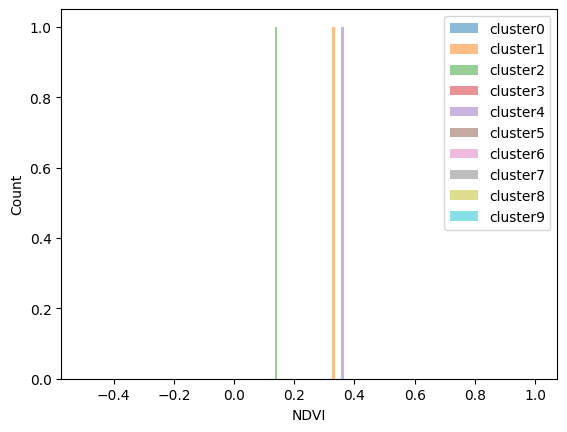

In [13]:
bins = np.linspace(-0.5, 1, 150)
for cluster in range(n_cluster_optimal):
    td_cluster=td_single_class[td_single_class['cluster']==cluster]
    td_cluster=td_cluster['NDVI_2'].to_numpy()
    plt.hist(td_cluster,bins, alpha=0.5, label='cluster'+str(cluster),rwidth=0.8);
    plt.legend()
    plt.xlabel('NDVI')
    plt.ylabel('Count')

We now filter the training features/points based on the cluster size. Here we assume cluster size lower than 10% of the overall sample szie are likely to be misclassified or changed samples.    
>Note: Depending on your own training data the K-Means method may not work well, so it is recommanded that you have more understanding on your training points and test on how it works, e.g. check if it successfully filtered out the points you believe were misclassified while keeping good training samples. You should also try to adjust the cluster size threshold if it doesn't effectively remove false samples.

There are also other options for removal of outliers which can be tested on, e.g. check [here](https://scikit-learn.org/stable/modules/outlier_detection.html) for using scikit-learn for outlier detection.

In [14]:
frequency_threshold=0.1 # threshold of cluter frequency
cluster_frequency=td_single_class['cluster'].map(td_single_class['cluster'].value_counts(normalize=True)) # calculate cluster frequencies for the training samples
td_single_class['cluster_frequency']=cluster_frequency # append as a column
td_single_class_filtered=td_single_class[td_single_class['cluster_frequency']>=frequency_threshold] # filter by cluster frequency
print('Number of training data after filtering: ',len(td_single_class_filtered))

Number of training data after filtering:  3


Through comparing the number of training points before and after the filtering you would know if there's any points filtered out. Optionally you can display the points before and after filtering:

In [15]:
td_single_class.explore(
    tiles = "https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}", 
    attr ='Imagery @2022 Landsat/Copernicus, Map data @2022 Google',
    popup=True,
    cmap='viridis',
    style_kwds=dict(radius= 5, color= 'red', fillOpacity= 0.8, fillColor= 'red', weight= 3),
    )

In [16]:
td_single_class_filtered.explore(
    tiles = "https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}", 
    attr ='Imagery @2022 Landsat/Copernicus, Map data @2022 Google',
    popup=True,
    cmap='viridis',
    style_kwds=dict(radius= 5, color= 'blue', fillOpacity= 0.8, fillColor= 'blue', weight= 3),
    )

**Note**: If you want to fine-tune the number of clusters for another class, simply change the `class_value` to another class value and re-run the steps within this `Training data clustering - example for one class` section. One you are happy with the optimal numbers of clusters, change below dictionary `None` to the optimal number for each class:

In [17]:
optimal_clusters={1:None, 5: None, 7: None,  9: None, 10: None, 11: None,  12: None,  13: None,  14: None}

## Training data clustering - all classes
To implement above clustering and filtering training features for all class, let's put the steps together and iterate through all classes. Here we append filtered features for all classes into a single dataframe `training_features_filtered`. Note if you don't change above dictionary `optimal_clusters` the script will still use the `find_clusters_KMeans` to find the optimal number of clusters based on the Calinski-Harabasz score:

In [18]:
training_features_filtered=None # filtered training data for all classes
frequency_threshold=0.1 # threshold of cluter frequency
for class_value in lc_classes: # filtering training data for each class
    #i=1 # test for first class
    print('Processing class ',class_value)
    rand_features_single_class=rand_samples_features[rand_samples_features[class_attr]==class_value].reset_index(drop=True)
    np_rand_features=rand_features_single_class.to_numpy()[:,1:]
    if optimal_clusters[class_value] is None:
        if np_rand_features.shape[0]<=2:
            print('can not fit kmeans for no more than 2 samples, skipping clustering')
        else:
            n_cluster_optimal,kmeans_model_optimal,labels_optimal=find_clusters_KMeans(np_rand_features,min_cluster=5,max_cluster=20)
    else:
        if np_rand_features.shape[0]<=2:
            print('can not fit kmeans for no more than 2 samples, skipping clustering')
        else:
            n_cluster_optimal,kmeans_model_optimal,labels_optimal=find_clusters_KMeans(np_rand_features,min_cluster=optimal_clusters[class_value],max_cluster=optimal_clusters[class_value])

    # subset original training points for this class
    td_single_class=training_features[training_features[class_attr]==class_value].reset_index(drop=True)
    print('Number of training pints for the class: ',len(td_single_class))
    np_td_single_class=td_single_class.to_numpy()[:,-9:-3]
    # predict clustering labels
    if kmeans_model_optimal is None:
        td_single_class_filtered=td_single_class.copy()
        td_single_class_filtered['cluster']=0
        td_single_class_filtered['cluster_frequency']=1
    else:
        labels_kmeans = kmeans_model_optimal.predict(np_td_single_class)
        # append clustering results to pixel coordinates
        td_single_class['cluster']=labels_kmeans
        cluster_frequency=td_single_class['cluster'].map(td_single_class['cluster'].value_counts(normalize=True)) # calculate cluster frequencies for the training samples
        td_single_class['cluster_frequency']=cluster_frequency # append as a column
        td_single_class_filtered=td_single_class[td_single_class['cluster_frequency']>=frequency_threshold] # filter by cluster frequency
        print('Number of training data after filtering: ',len(td_single_class_filtered))
    
    # append the filtered training points of this class to final filtered training data
    if training_features_filtered is None:
        training_features_filtered=td_single_class_filtered
    else:
        training_features_filtered=pd.concat([training_features_filtered, td_single_class_filtered])

Processing class  10.0
Calinski-Harabasz score for  5  clusters is:  87.59687062896106
Calinski-Harabasz score for  6  clusters is:  80.00930009259388
Calinski-Harabasz score for  7  clusters is:  72.50628340522834
Calinski-Harabasz score for  8  clusters is:  66.38863116815503
Calinski-Harabasz score for  9  clusters is:  63.27600443872256
Calinski-Harabasz score for  10  clusters is:  60.72420307605137
Calinski-Harabasz score for  11  clusters is:  57.69613917427853
Calinski-Harabasz score for  12  clusters is:  55.601478170774854
Calinski-Harabasz score for  13  clusters is:  55.43604174030088
Calinski-Harabasz score for  14  clusters is:  52.47641590272379
Calinski-Harabasz score for  15  clusters is:  52.8527527729325
Calinski-Harabasz score for  16  clusters is:  50.52169202251151
Calinski-Harabasz score for  17  clusters is:  51.384998102955166
Calinski-Harabasz score for  18  clusters is:  47.73113570798757
Calinski-Harabasz score for  19  clusters is:  47.86852368418984
Calins

## Export filtered training features
Once we've filtered the training signatures, we can write the filtered data to disk, which will allow us to import the data in the next step(s) of the workflow. Here we export as text file:

In [19]:
output_file = "Results/Training_features_filtered.txt"
training_features_filtered.iloc[:,:-5].to_csv(output_file, header=True, index=None, sep=' ')